In [1]:
import glob
import os
import numpy as np
import gzip
import torch
import pickle
import sys
import json
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

sys.path.append('../')
from brush_stroke import BrushStroke

c:\Users\Ldori\miniconda3\envs\SketchAI\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cache_dir = '../caches/vae_sharpie_final'
canvases_before_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'canvases_before_*.npy'))
canvases_after_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'canvases_after_*.npy'))
brush_strokes_fns = glob.glob(os.path.join(cache_dir, 'stroke_library', 'stroke_parameters*.npy'))

# Ensure each of the files is in the order they were recorded in
canvases_before_fns = sorted(canvases_before_fns)
canvases_after_fns = sorted(canvases_after_fns)
brush_strokes_fns = sorted(brush_strokes_fns)

# Load data
canvases_before = None
for canvases_before_fn in canvases_before_fns:
    with gzip.GzipFile(canvases_before_fn,'r') as f:
        s = np.load(f, allow_pickle=True).astype(np.float32)/255.
        canvases_before = s if canvases_before is None else np.concatenate([canvases_before, s])

canvases_after = None
for canvases_after_fn in canvases_after_fns:
    with gzip.GzipFile(canvases_after_fn,'r') as f:
        s = np.load(f, allow_pickle=True).astype(np.float32)/255.
        canvases_after = s if canvases_after is None else np.concatenate([canvases_after, s])

brush_strokes = []
for brush_strokes_fn in brush_strokes_fns:
    bs = pickle.load(open(brush_strokes_fn,'rb'))
    brush_strokes = bs if brush_strokes is None else np.concatenate([brush_strokes, bs]) 
for b in brush_strokes:
    b.vae_name = os.path.join('..', b.vae_name)

canvases_before = torch.from_numpy(canvases_before).float().nan_to_num()
canvases_after = torch.from_numpy(canvases_after).float().nan_to_num()
canvases_before = torch.mean(canvases_before, dim=3)
canvases_after = torch.mean(canvases_after, dim=3)

with open(os.path.join(cache_dir, 'stroke_library', 'stroke_settings_during_library.json'), 'r') as f:
    settings = json.load(f)
    CANVAS_WIDTH_M = settings['CANVAS_WIDTH_M']
    CANVAS_HEIGHT_M = settings['CANVAS_HEIGHT_M']

paths = []
starts = []
for b in brush_strokes:
    path = b.get_path()[:,:2]
    path = torch.flip(path, dims=(1,)) 
    path[:, 0] *= -1
    starts.append([b.yt, b.xt])
    paths.append(path.detach())
starts = torch.tensor(starts)
paths = torch.stack(paths, dim=0)

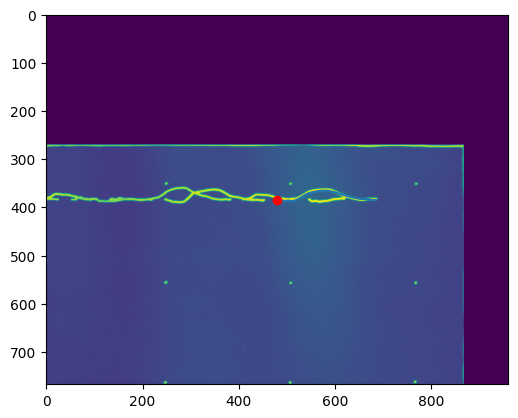

In [3]:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

def shift_to_center(path, start, canvas_before, canvas_after):
    path = path.clone().numpy()
    start = start.clone().numpy()
    canvas_before = canvas_before.clone().numpy()
    canvas_after = canvas_after.clone().numpy()

    shift = 0.5 - start
    h, w = canvas_before.shape
    canvas_shift = np.array([shift[0] * h, shift[1] * w])
    canvas_shift = np.round(canvas_shift).astype(int)
    canvas_before = shift_image(canvas_before, canvas_shift[1], canvas_shift[0])
    canvas_after = shift_image(canvas_after, canvas_shift[1], canvas_shift[0])

    path[:, 0] /= CANVAS_HEIGHT_M
    path[:, 1] /= CANVAS_WIDTH_M
    path += 0.5
    path = np.flip(path, axis=1)

    return path, canvas_before, canvas_after

idx = 4
path, canvas_before, canvas_after = shift_to_center(paths[idx], starts[idx], canvases_before[idx], canvases_after[idx])
h, w = canvas_after.shape
plt.plot(path[:, 0]*w, path[:, 1]*h)
# plot dot at path[0]
plt.plot(path[0, 0]*w, path[0, 1]*h, 'ro')
plt.imshow(canvas_after)

In [4]:
xs = []
ys = []
for i in range(len(paths)):
    path, canvas_before, canvas_after = shift_to_center(paths[i], starts[i], canvases_before[i], canvases_after[i])
    path = torch.from_numpy(path.copy())
    canvas_before = torch.from_numpy(canvas_before.copy())
    canvas_after = torch.from_numpy(canvas_after.copy())
    xs.append(path)
    ys.append((canvas_before, canvas_after))

num_val = 10
train_xs = xs[:-num_val]
train_ys = ys[:-num_val]
test_xs = xs[-num_val:]
test_ys = ys[-num_val:]

class StrokeDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

train_dataset = StrokeDataset(train_xs, train_ys)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataset = StrokeDataset(test_xs, test_ys)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def fit_renderer(renderer, dataloader, epochs, lr):
    optim = torch.optim.Adam(renderer.parameters(), lr=lr)
    for epoch in range(epochs):
        for traj, (canvas_before, canvas_after) in dataloader:
            traj = traj.to(device)
            canvas_before = canvas_before.to(device)
            canvas_after = canvas_after.to(device)

            pred = renderer(traj)
            pred = transforms.Resize((canvas_after.shape[1], canvas_after.shape[2]), antialias=True)(pred)
            pred = pred + canvas_before*(1-pred)

            loss = torch.mean(torch.abs(pred - canvas_after))
            optim.zero_grad()
            loss.backward()
            optim.step()

def evaluate_renderer(renderer, dataloader):
    tot_loss = 0
    cnt = 0
    results = []
    for traj, (canvas_before, canvas_after) in dataloader:
        traj = traj.to(device)
        canvas_before = canvas_before.to(device)
        canvas_after = canvas_after.to(device)

        pred = renderer(traj)
        pred = transforms.Resize((canvas_after.shape[1], canvas_after.shape[2]), antialias=True)(pred)
        pred = pred + canvas_before*(1-pred)

        for i in range(len(pred)):
            results.append((pred[i].detach().cpu().numpy(), canvas_after[i].detach().cpu().numpy()))

        loss = torch.sum(torch.mean(torch.abs(pred - canvas_after), dim=(1,2)))
        tot_loss += loss
        cnt += len(pred)
    loss = tot_loss / cnt
    return loss, results

from custom_renderer import CustomRenderer
from conv_renderer import ConvRenderer
from coordconv_renderer import CoordConvRenderer
# from diffvg_renderer import DiffVGRenderer
from custom_unet_renderer import CustomUnetRenderer

configs = [
    {
        'renderer': CustomRenderer(256),
        'epochs': 40,
        'lr': 1e-1
    },
    {
        'renderer': ConvRenderer(),
        'epochs': 2000,
        'lr': 1e-3
    },
    {
        'renderer': CoordConvRenderer(),
        'epochs': 2000,
        'lr': 1e-3
    },
    {
        'renderer': CustomUnetRenderer(),
        'epochs': 2000,
        'lr': 1e-3
    },
    # {
    #     'renderer': DiffVGRenderer(256),
    #     'epochs': 40,
    #     'lr': 1e-1
    # }
]

In [6]:
idx = 3
config = configs[idx]
config['renderer'].to(device)
fit_renderer(config['renderer'], train_dataloader, epochs=config['epochs'], lr=config['lr'])

In [ ]:
loss, results = evaluate_renderer(config['renderer'], test_dataloader)

tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>)


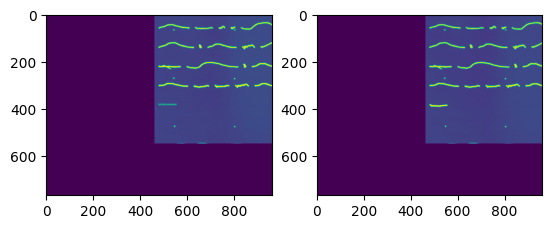

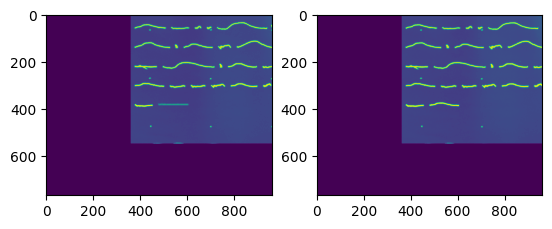

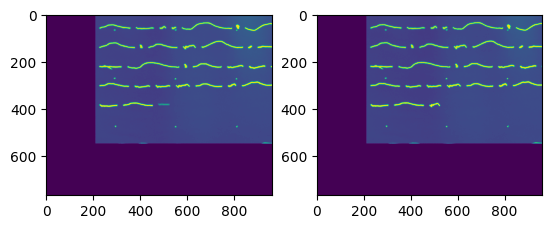

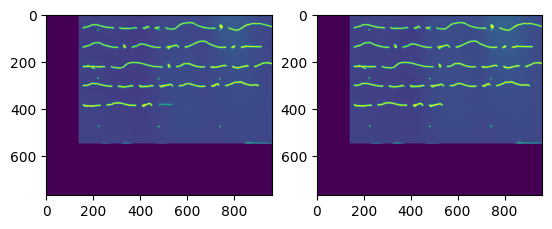

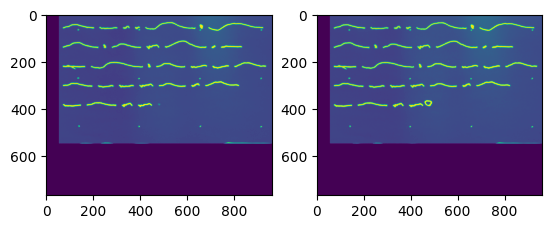

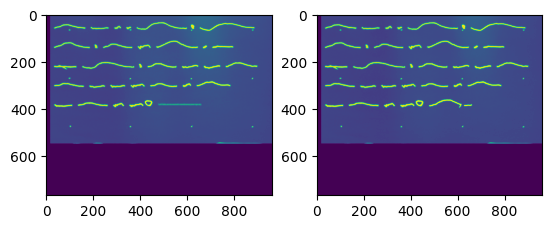

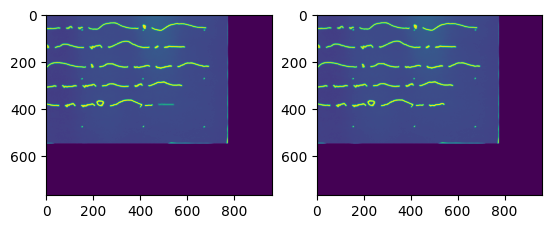

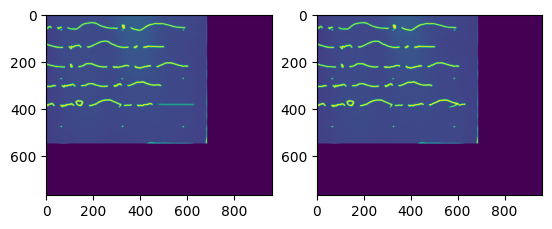

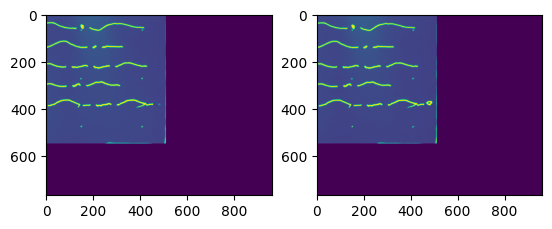

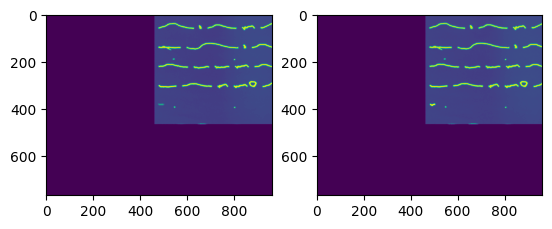

In [ ]:
print(loss)
for i in range(len(results)):
    plt.subplot(1, 2, 1)
    plt.imshow(results[i][0])
    plt.subplot(1, 2, 2)
    plt.imshow(results[i][1])
    plt.show()